In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from getSIDMdata_generator import get_tf_DataSet as getGenerators
import scienceplots
plt.style.use(["science", "grid"])

Objectives
----------
- To see whether augmentation of the data helps the CNN
- In this module I test
    - Rotation & Flipping
    - Cropping
    - Zooming
    - Shuffling
    - Contrast

Conclusions
-----------
- It seems that just rotation and flipping is the only thing that improves.

In [10]:
epochs=80

#### Fiducial Model

In [ ]:
train, test = getGenerators(augment_data=False, simulationNames=['CDM','SIDM0.1','SIDM1'], 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl')

fiducial = simpleCNN.getModel_ds(3)
history = fiducial.fit(
  x=train,
  validation_data=test,
  epochs=epochs
)

#### Rotation and Flipping

In [ ]:
train, test = getGenerators(augment_data=True, simulationNames=['CDM','SIDM0.1','SIDM1'], 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl')

augmented_model = simpleCNN.getModel_ds(3)
augmented_history = augmented_model.fit(
  x=train,
  validation_data=test,
  epochs=epochs
)

####  Shuffling

In [ ]:
augmented_shuffled_train_ds, augmented_shuffled_test_ds  = get_tf_DataSet(augment_data=False, shuffle_data=True)
augmented_shuffled = simpleCNN.getModel_ds(augmented_shuffled_train_ds.num_classes)

epochs=20
au_history = augmented_shuffled.fit(
  x=augmented_shuffled_train_ds,
  validation_data=augmented_shuffled_test_ds,
  epochs=epochs
)

####  Cropping

In [ ]:
augmented_cropped_train_ds, augmented_cropped_test_ds  = get_tf_DataSet(crop_data=True)
augmented_cropped = simpleCNN.getModel_ds(augmented_cropped_train_ds.num_classes)

epochs=20
au_history = augmented_cropped.fit(
  x=augmented_cropped_train_ds,
    validation_data=augmented_cropped_test_ds,
  epochs=epochs
)

#### Zooming

In [ ]:
augmented_zoom_train_ds, augmented_zoom_test_ds  = get_tf_DataSet( zoom=True)
augmented_zoom = simpleCNN.getModel_ds(augmented_zoom_train_ds.num_classes)
epochs=20
au_history = augmented_zoom.fit(
  x=augmented_zoom_train_ds,
    validation_data=augmented_zoom_test_ds,
  epochs=epochs
)

#### Contrasting 

In [ ]:
augmented_contrast_train_ds, augmented_contrast_test_ds  = get_tf_DataSet( contrast=True)
augmented_contrast = simpleCNN.getModel_ds(augmented_contrast_train_ds.num_classes)
epochs=20
au_history = augmented_contrast.fit(
  x=augmented_contrast_train_ds,
    validation_data=augmented_contrast_test_ds,
  epochs=epochs
)

#### Rotation and Flipping and Cropping

In [ ]:
rot_flip_crop_train_ds, rot_flip_crop_test_ds  = get_tf_DataSet( augment_data=True, crop_data=True)
rot_flip_crop = simpleCNN.getModel_ds(rot_flip_crop_train_ds.num_classes)
epochs=20
au_history = rot_flip_crop.fit(
  x=rot_flip_crop_train_ds,
    validation_data=rot_flip_crop_test_ds,
  epochs=epochs
)

### Results

In [19]:
models = [ fiducial,  augmented_model] 
savethese = [ i.history.history for i in models ]
pkl.dump(savethese, open("pickles/augment_test.pkl","wb"))

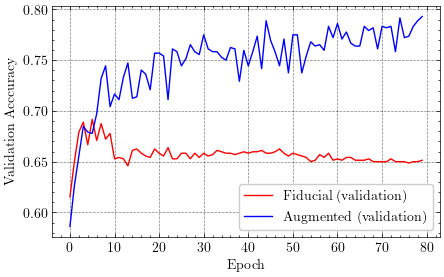

In [23]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')

models = pkl.load( open("pickles/augment_test.pkl","rb"))
names = ['Fiducial','Augmented','shuffle','cropped','zoom', 'contrast', 'RFC']
c = ['r','b','g','c','y','k','orange']
for i, iModel in enumerate(models):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], label="%s (validation)" % (names[i]), c=c[i])

plt.legend(loc=4)
plt.savefig("../plots/augment_test.pdf")

## Old Stuff

In [ ]:
(train_images, att_train, train_labels), testSets = getData(  indexFileRoot='pickles/testIndexesRot', testTrainSplit=0.15)
test_labels, test_images, test_ids = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
        test_ids = testSets[i]['clusterID']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        test_ids = np.vstack((test_ids, testSets[i]['clusterID']))
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]

Test Rotations

In [ ]:

color=['r','g','b','c','y','o']
fig, [ax1, ax2]  = plt.subplots( 1, 2, figsize=(10,5))
#Test the dropout on reliability
for i, nRotations in enumerate([1, 5, 10, 20]):
    allRotatedImages = []
    allRotatedLabels = []
    
    imageSize = train_images[0,:,:,0].shape[0]
    

    csv_file = 'pickles/testRotations_%0.2f_finalLayer_2048_dropout_0.3.csv' % nRotations
    
    csv_logger = CSVLogger(csv_file, append=True)
    model_file =  'pickles/testRotations_%0.2f_finalLayer_2048_dropout_0.3.h5' % nRotations
    
    if os.path.isfile( csv_file ):
        previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
        initial_epoch = previousEpochs.shape[0]
    else:
        initial_epoch = 0
        
    if os.path.isfile(model_file):
        print("FOUND PREVIOUS MODEL, LOADING...")
        model = models.load_model(model_file)
    else:
        for iImage in range(train_images.shape[0]):
            for iAngle in range(nRotations):
                rotAngle = np.random.uniform(0, 360)
                rotatedImage = rotate(train_images[iImage, :,:, 0], rotAngle)
                centralPix = rotatedImage.shape[0]//2
                croppedImage = rotatedImage[centralPix-imageSize//2:centralPix+imageSize//2,centralPix-imageSize//2:centralPix+imageSize//2 ]
                allRotatedImages.append(croppedImage )
                allRotatedLabels.append( train_labels[iImage,0])
        allRotatedImages = np.array(allRotatedImages)
        newImages = allRotatedImages[:,:,:,np.newaxis]
        allRotatedLabels = np.array(allRotatedLabels)
        newLabels = allRotatedLabels[:,np.newaxis]


        model = simpleCNN.getModel( inputShape, nClasses, dropout=0.2, finalLayer=2048, learning_rate=3e-6)
        
        
        history = model.fit(newImages, newLabels, epochs=10, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
        model.save(model_file)

    trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
    ax1.plot(trainHistory['loss'], label='%i' % nRotations, color=color[i])
    ax1.plot(trainHistory['val_loss'], label='%i' % nRotations, linestyle='--', color=color[i])
    
    ax2.plot(trainHistory['accuracy'], label = '%i' % nRotations, linestyle='-', color=color[i]) 
    ax2.plot(trainHistory['val_accuracy'], label = '%i' % nRotations, linestyle='--', color=color[i]) 
ax1.legend()   
ax2.legend()

Test Translations

In [ ]:

color=['r','g','b','c','y','o']
fig, [ax1, ax2]  = plt.subplots( 1, 2, figsize=(10,5))
#Test the dropout on reliability
for i, nTranslations in enumerate([1, 5, 10]):
    allRotatedImages = []
    allRotatedLabels = []
    
    imageSize = train_images[0,:,:,0].shape[0]
    

    csv_file = 'pickles/testTranslate_%0.2f_finalLayer_2048_dropout_0.3.csv' % nTranslations
    
    csv_logger = CSVLogger(csv_file, append=True)
    model_file =  'pickles/testTranslate_%0.2f_finalLayer_2048_dropout_0.3.h5' % nTranslations
    
    if os.path.isfile( csv_file ):
        previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
        initial_epoch = previousEpochs.shape[0]
    else:
        initial_epoch = 0
        
    if os.path.isfile(model_file):
        print("FOUND PREVIOUS MODEL, LOADING...")
        model = models.load_model(model_file)
    else:
        for iImage in range(train_images.shape[0]):
            for iAngle in range(nTranslations):
                xTranslation = np.random.randint(-4, 4)
                yTranslation = np.random.randint(-4, 4)
                
                translatedX = np.roll( train_images[iImage, :,:, 0], xTranslation, axis=0)
                translatedXY = np.roll( translatedX, yTranslation, axis=1)

                allRotatedImages.append(translatedXY )
                allRotatedLabels.append( train_labels[iImage,0])
                
        allRotatedImages = np.array(allRotatedImages)
        newImages = allRotatedImages[:,:,:,np.newaxis]
        allRotatedLabels = np.array(allRotatedLabels)
        newLabels = allRotatedLabels[:,np.newaxis]


        model = simpleCNN.getModel( inputShape, nClasses, dropout=0.2, finalLayer=2048, learning_rate=3e-6)
        
        
        history = model.fit(newImages, newLabels, epochs=10, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
        model.save(model_file)

    trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
    ax1.plot(trainHistory['loss'], label='%i' % nTranslations, color=color[i])
    ax1.plot(trainHistory['val_loss'], label='%i' % nTranslations, linestyle='--', color=color[i])
    
    ax2.plot(trainHistory['accuracy'], label = '%i' % nTranslations, linestyle='-', color=color[i]) 
    ax2.plot(trainHistory['val_accuracy'], label = '%i' % nTranslations, linestyle='--', color=color[i]) 
ax1.legend()   
ax2.legend()

Test Rescale

In [ ]:
from scipy.interpolate import interp2d

color=['r','g','b','c','y','o']
fig, [ax1, ax2]  = plt.subplots( 1, 2, figsize=(10,5))
#Test the dropout on reliability
imageSize = train_images[0,:,:,0].shape
centrePix = imageSize[0] // 2

xVector = np.arange(imageSize[0])-centrePix



for i, nRescale in enumerate([1, 5, 10, 20]):
    allRotatedImages = []
    allRotatedLabels = []
    
    

    csv_file = 'pickles/testRescale_%0.2f_finalLayer_2048_dropout_0.3.csv' % nRescale
    
    csv_logger = CSVLogger(csv_file, append=True)
    model_file =  'pickles/testRescale_%0.2f_finalLayer_2048_dropout_0.3.h5' % nRescale
    
    if os.path.isfile( csv_file ):
        previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
        initial_epoch = previousEpochs.shape[0]
    else:
        initial_epoch = 0
        
    if os.path.isfile(model_file):
        print("FOUND PREVIOUS MODEL, LOADING...")
        model = models.load_model(model_file)
    else:
        for iImage in range(train_images.shape[0]):
            for iAngle in range(nRescale):
                rescale = 10**np.random.uniform(np.log10(0.13), np.log10(1.3))
                
                newSize = np.int(rescale*imageSize[0])
                

                newXVector = (np.arange(imageSize[0])-centrePix)*rescale

                
                interpFunc = interp2d( xVector, xVector, train_images[iImage, :,:, 0].reshape( np.prod(imageSize)))
                
                newImage = interpFunc( newXVector, newXVector)
                
                
      
                allRotatedImages.append(newImage )
                allRotatedLabels.append( train_labels[iImage,0])
        allRotatedImages = np.array(allRotatedImages)
        newImages = allRotatedImages[:,:,:,np.newaxis]
        allRotatedLabels = np.array(allRotatedLabels)
        newLabels = allRotatedLabels[:,np.newaxis]


        model = simpleCNN.getModel( inputShape, nClasses, dropout=0.2, finalLayer=2048, learning_rate=3e-6)
        
        
        history = model.fit(newImages, newLabels, epochs=10, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
        model.save(model_file)

    trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
    ax1.plot(trainHistory['loss'], label='%i' % nRescale, color=color[i])
    ax1.plot(trainHistory['val_loss'], label='%i' % nRescale, linestyle='--', color=color[i])
    
    ax2.plot(trainHistory['accuracy'], label = '%i' % nRescale, linestyle='-', color=color[i]) 
    ax2.plot(trainHistory['val_accuracy'], label = '%i' % nRescale, linestyle='--', color=color[i]) 
ax1.legend()   
ax2.legend()

Test Flipping

In [ ]:

color=['r','g','b','c','y','o']
fig, [ax1, ax2]  = plt.subplots( 1, 2, figsize=(10,5))
for i, nFlip in enumerate([1, 2, 3]):
    allRotatedImages = []
    allRotatedLabels = []
    
    

    csv_file = 'pickles/testFlip_%0.2f_finalLayer_2048_dropout_0.3.csv' % nFlip
    
    csv_logger = CSVLogger(csv_file, append=True)
    model_file =  'pickles/testFlip_%0.2f_finalLayer_2048_dropout_0.3.h5' % nFlip
    
    if os.path.isfile( csv_file ):
        previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
        initial_epoch = previousEpochs.shape[0]
    else:
        initial_epoch = 0
        
    if os.path.isfile(model_file):
        print("FOUND PREVIOUS MODEL, LOADING...")
        model = models.load_model(model_file)
    else:
        for iImage in range(train_images.shape[0]):
            for iFlip in range(nFlip):
                if iFlip == 0:
                    flippedImage = train_images[iImage, :,:, 0]
                elif iFlip == 1:
                    flippedImage = train_images[iImage, ::-1,:, 0]
                elif iFlip == 2:
                    flippedImage = train_images[iImage, :,::-1, 0]

   
                allRotatedImages.append( flippedImage )
                allRotatedLabels.append( train_labels[iImage,0])
        
        allRotatedImages = np.array(allRotatedImages)
        newImages = allRotatedImages[:,:,:,np.newaxis]
        allRotatedLabels = np.array(allRotatedLabels)
        newLabels = allRotatedLabels[:,np.newaxis]

        model = simpleCNN.getModel( inputShape, nClasses, dropout=0.2, finalLayer=2048, learning_rate=3e-6)
        
        
        history = model.fit(newImages, newLabels, epochs=10, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
        model.save(model_file)

    trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
    ax1.plot(trainHistory['loss'], label='%i' % nFlip, color=color[i])
    ax1.plot(trainHistory['val_loss'], label='%i' % nFlip, linestyle='--', color=color[i])
    
    ax2.plot(trainHistory['accuracy'], label = '%i' % nFlip, linestyle='-', color=color[i]) 
    ax2.plot(trainHistory['val_accuracy'], label = '%i' % nFlip, linestyle='--', color=color[i]) 
ax1.legend()   
ax2.legend()

Test augmentations individually

In [ ]:

color=['r','g','b','c','y','o']
fig, [ax1, ax2]  = plt.subplots( 1, 2, figsize=(10,5))

#Flipping
nFlip = 2
nRotations = 10
imageSize = train_images[0,:,:,0].shape[0]

allRotatedImages = []
allRotatedLabels = []
    

csv_file = 'pickles/testAug_finalLayer_2048_dropout_0.3.csv' 
    
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/testAug_finalLayer_2048_dropout_0.3.h5' 
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    for iImage in range(train_images.shape[0]):
        for iFlip in range(nFlip):
            if iFlip == 0:
                flippedImage = train_images[iImage, :,:, 0]
            elif iFlip == 1:
                flippedImage = train_images[iImage, ::-1,:, 0]

           
            allRotatedImages.append( flippedImage )
            allRotatedLabels.append( train_labels[iImage,0])
        
        for iRotation in range(nRotations):
            rotAngle = np.random.uniform(0, 360)
            rotatedImage = rotate(train_images[iImage, :,:, 0], rotAngle)
            centralPix = rotatedImage.shape[0]//2
            croppedImage = rotatedImage[centralPix-imageSize//2:centralPix+imageSize//2,centralPix-imageSize//2:centralPix+imageSize//2 ]
            allRotatedImages.append(croppedImage )
            allRotatedLabels.append( train_labels[iImage,0])  
            
            
            
    allRotatedImages = np.array(allRotatedImages)
    newImages = allRotatedImages[:,:,:,np.newaxis]
    allRotatedLabels = np.array(allRotatedLabels)
    newLabels = allRotatedLabels[:,np.newaxis]
    print("Training size is %i" % newImages.shape[0])
    model = simpleCNN.getModel( inputShape, nClasses, dropout=0.2, finalLayer=2048, learning_rate=3e-6)
        
        
    history = model.fit(newImages, newLabels, epochs=10, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
    model.save(model_file)

trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
ax1.plot(trainHistory['loss'], label='Aug', color=color[0])
ax1.plot(trainHistory['val_loss'], label='Aug', linestyle='--', color=color[0])
    
ax2.plot(trainHistory['accuracy'], label = 'Aug', linestyle='-', color=color[0]) 
ax2.plot(trainHistory['val_accuracy'], label = 'Aug', linestyle='--', color=color[0]) 

neurons = 2048
csv_file =  'pickles/testFinalLayerDensity_%i.csv' % neurons
trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
ax1.plot(trainHistory['loss'], label='No Aug', color=color[1])
ax1.plot(trainHistory['val_loss'], label='No Aug', linestyle='--', color=color[1])
    
ax2.plot(trainHistory['accuracy'], label = 'No Aug', linestyle='-', color=color[1]) 
ax2.plot(trainHistory['val_accuracy'], label = 'No Aug', linestyle='--', color=color[1]) 


ax1.legend()   
ax2.legend()

In [ ]:
color=['r','g','b','c','y','o']
fig, [ax1, ax2]  = plt.subplots( 1, 2, figsize=(10,5))

csv_file = 'pickles/testAugComb_finalLayer_2048_dropout_0.3.csv'

trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
#ax1.plot(trainHistory['loss'], label='Aug Indiv', color=color[0])
ax1.plot(trainHistory['val_loss'], label='Aug Indiv', linestyle='--', color=color[0])
    
#ax2.plot(trainHistory['accuracy'], label = 'Aug Comb', linestyle='-', color=color[0]) 
ax2.plot(trainHistory['val_accuracy'], label = 'Aug Comb', linestyle='--', color=color[0]) 


ax1.legend()   
ax2.legend()


csv_file = 'pickles/testAug_finalLayer_2048_dropout_0.3.csv' 

trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
#ax1.plot(trainHistory['loss'], label='Aug Indiv', color=color[1])
ax1.plot(trainHistory['val_loss'], label='Aug Indiv', linestyle='--', color=color[1])
    
#ax2.plot(trainHistory['accuracy'], label = 'Aug Indiv', linestyle='-', color=color[1]) 
ax2.plot(trainHistory['val_accuracy'], label = 'Aug Indiv', linestyle='--', color=color[1]) 


ax1.legend()   
ax2.legend()


neurons = 2048
csv_file =  'pickles/testFinalLayerDensity_%i.csv' % neurons
trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
#ax1.plot(trainHistory['loss'], label='No Aug', color=color[1])
ax1.plot(trainHistory['val_loss'], label='No Aug', linestyle='--', color=color[2])
    
#ax2.plot(trainHistory['accuracy'], label = 'No Aug', linestyle='-', color=color[2]) 
ax2.plot(trainHistory['val_accuracy'], label = 'No Aug', linestyle='--', color=color[2]) 


csv_file =  'pickles/testAugCombAllChannel_finalLayer_64_dropout_0.3.csv'

trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
#ax1.plot(trainHistory['loss'], label='No Aug', color=color[1])
ax1.plot(trainHistory['val_loss'], label='Multi-Channel Aug', linestyle='--', color=color[3])
    
#ax2.plot(trainHistory['accuracy'], label = 'No Aug', linestyle='-', color=color[2]) 
ax2.plot(trainHistory['val_accuracy'], label = 'Multi-Channel Aug', linestyle='--', color=color[3]) 

csv_file =  'pickles/testAugCombAllChannel_finalLayer_512_dropout_0.3.csv'

trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
#ax1.plot(trainHistory['loss'], label='No Aug', color=color[1])
ax1.plot(trainHistory['val_loss'], label='Multi-Channel Aug 512', linestyle='--', color=color[4])
    
#ax2.plot(trainHistory['accuracy'], label = 'No Aug', linestyle='-', color=color[2]) 
ax2.plot(trainHistory['val_accuracy'], label = 'Multi-Channel Aug 512', linestyle='--', color=color[4]) 



ax1.legend()   
ax2.legend()



In [ ]:
    (train_images, att_train, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexesRot', testTrainSplit=0.15, nChannels=2)
    
    test_labels, test_images, test_ids = None, None, None
    for i in testSets.keys():
        if test_labels is None:
            test_images = testSets[i]['images']
            test_labels = testSets[i]['labels']
            test_ids = testSets[i]['clusterID']
        else:
            test_labels = np.vstack((test_labels, testSets[i]['labels']))
            test_images = np.vstack((test_images, testSets[i]['images']))
            test_ids = np.vstack((test_ids, testSets[i]['clusterID']))
    nClasses = len(np.unique(train_labels))
    

    #Flipping
    nFlip = 2
    nRotations = 10


    allRotatedImages = []
    allRotatedLabels = []
    
    imageSize = train_images[0, :,:, 0].shape[0]//2
    csv_file = 'pickles/testAugCombAllChannel_finalLayer_2048_dropout_0.3.csv' 
    
    csv_logger = CSVLogger(csv_file, append=True)
    model_file =  'pickles/testAugCombAllChannel_finalLayer_2048_dropout_0.3.h5' 
    
    #if os.path.isfile( csv_file ):
    #    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    #    initial_epoch = previousEpochs.shape[0]
    #else:
    #    initial_epoch = 0
        
    if os.path.isfile(model_file):
        print("FOUND PREVIOUS MODEL, LOADING...")
        model = models.load_model(model_file)
    else:
        for iImage in range(train_images.shape[0]):
            
            for iRotation in range(nRotations):
                rotAngle = np.random.uniform(0, 360)
                for iFlip in range(nFlip):
                    if iFlip == 0:
                        flippedImage = train_images[iImage, :,:, :]
                    elif iFlip == 1:
                        flippedImage = train_images[iImage, ::-1,:, :]

                    
                    for iChannel in range(flippedImage.shape[-1]):
                        
                        rotatedImage = rotate(flippedImage[:,:,iChannel], rotAngle)
                        centralPix = rotatedImage.shape[0]//2
                        croppedImage = rotatedImage[centralPix-imageSize//2:centralPix+imageSize//2,\
                                                centralPix-imageSize//2:centralPix+imageSize//2 ]
                        if iChannel == 0:
                            finalImage = croppedImage
                        else:
                            finalImage = np.dstack( (finalImage, croppedImage))
                        
                    allRotatedImages.append( finalImage )
                    allRotatedLabels.append( train_labels[iImage,0])  
            
            
            
        allRotatedImages = np.array(allRotatedImages)
        newImages = allRotatedImages[:,:,:,np.newaxis]
        allRotatedLabels = np.array(allRotatedLabels)
        newLabels = allRotatedLabels[:,np.newaxis]
        print("Training size is %i" % newImages.shape[0])
        inputShape = allRotatedImages.shape[1:]    


In [ ]:
newImages.shape

In [ ]:
        #Need to reshape the testimages
        croppedTestImages = []
        
        for iImage in range(test_images.shape[0]):
            croppedImage = test_images[iImage, centralPix-imageSize//2:centralPix+imageSize//2,\
                                                centralPix-imageSize//2:centralPix+imageSize//2, :]
            croppedTestImages.append(croppedImage)
            
        croppedTestImages = np.array(croppedTestImages)

In [ ]:
model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, dropout=0.2, finalLayer=2048, learning_rate=3e-6)


In [ ]:
model.summary()

In [ ]:
        
history = model.fit(allRotatedImages, newLabels, epochs=10, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)